## Setup

In [31]:
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.engine import Engine
from data_setup import create_connection
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [6]:
def load_data(engine: Engine) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Loads data from tables as pd dataframes
    """
    with engine.connect() as conn:
        listings_df = pd.read_sql("SELECT * from listings", conn)
        neighborhood_df = pd.read_sql("SELECT * from neighborhoods", conn)
        groups_df = pd.read_sql("SELECT * from neighborhoodgroups", conn)
        review_df = pd.read_sql("SELECT * from reviews", conn)
    return listings_df, neighborhood_df, groups_df, review_df


In [7]:
engine = create_connection()
listings_df, neighborhood_df, groups_df, review_df = load_data(engine)

In [8]:
def execute_query(query):
    with engine.connect() as conn:
        query_result = pd.read_sql(query,conn)
    return query_result


In [9]:
#Neighborhood-centered queries

#  neighborhood group vs price
price_group = """SELECT G.group_name, L.price 
FROM listings L 
JOIN neighborhoodgroups G ON L.neighbourhood_group_id = G.group_id 
WHERE L.price IS NOT NULL 
ORDER BY G.group_name"""

#number of listings per neighborhood group
num_listings_group = """SELECT G.group_name, COUNT(l.id) as num_listings 
FROM listings L 
JOIN neighborhoodgroups G on L.neighbourhood_group_id = G.group_id
GROUP BY G.group_name 
ORDER BY num_listings DESC"""

# neighborhood vs price
price_nh = """SELECT N.neighbourhood, L.price 
FROM listings L 
JOIN Neighborhoods N on L.neighbourhood_id = N.neighborhood_id 
WHERE L.price IS NOT NULL 
ORDER BY L.price DESC"""


In [18]:
# Listing centered queries
#average price of room types
avg_price_room = """SELECT L.room_type, AVG(L.price) as avg_price 
FROM Listings L 
GROUP BY L.room_type 
ORDER BY avg_price DESC"""

nh_room_type = """SELECT L.room_type, L.price, N.neighbourhood 
FROM Listings L 
JOIN Neighborhoods N on L.neighbourhood_id = N.neighborhood_id 
WHERE L.price IS NOT NULL"""

# availability vs number_of_reviews
avail_num_reviews = """SELECT availability_365, number_of_reviews 
FROM Listings L 
ORDER BY number_of_reviews DESC"""

# =listings by (income) and their attributes
top_listings = """SELECT L.*, G.group_name, N.neighbourhood, (L.price * COALESCE(L.number_of_reviews_ltm,0)) as est_annual_income
FROM Listings L 
JOIN neighborhoodgroups G on L.neighbourhood_group_id = G.group_id 
JOIN Neighborhoods N on L.neighbourhood_id = N.neighborhood_id 
WHERE L.price IS NOT NULL 
    AND L.reviews_per_month IS NOT NULL
ORDER BY est_annual_income DESC
"""

# top most reviewed listing and their reviews (dates)
top_reviewed_listing = """WITH top_listings AS (
SELECT id 
FROM Listings 
WHERE reviews_per_month IS NOT NULL 
ORDER BY reviews_per_month DESC 
LIMIT 100)
SELECT L.id, L.reviews_per_month, R.date 
FROM top_listings T 
JOIN Reviews R on T.id = R.listing_id 
JOIN Listings L on L.id = R.listing_id 
ORDER BY L.reviews_per_month DESC, R.date
"""


In [19]:
price_group_df = execute_query(price_group)
num_listings_group_df = execute_query(num_listings_group)
price_nh_df = execute_query(price_nh)
nh_room_type_df = execute_query(nh_room_type)
avg_price_room_df = execute_query(avg_price_room)
avail_num_reviews_df = execute_query(avail_num_reviews)
top_listings_df = execute_query(top_listings)
top_reviewed_listing_df = execute_query(top_reviewed_listing)



### Data Wrangling


In [40]:
#handle missing data (na), impute data, and remove outiers
def clean_data(df, drop_cols=None, fill_cols=None, encode_cols=None, drop_na_cols=None):
    """
    drop_cols: list : columns to be dropped
    fill_cols: dict: {col: col to be filled, value: filling value}
    encode_cols: list: columns to be one hot encoded
    drop_na_cols: list: columns with na to be dropped
    """
    cleaned_df = df.copy()
    if drop_cols:
        existing_drop_cols = [col for col in drop_cols if col in cleaned_df.columns]
        if existing_drop_cols:
            cleaned_df.drop(columns=existing_drop_cols)

    if fill_cols:
        for col, value, in fill_cols.items():
            if col in cleaned_df.columns:
                cleaned_df[col] = cleaned_df[col].fillna(value)

    if encode_cols:
        existing_encode_cols = [col for col in encode_cols if col in cleaned_df.columns]
        if existing_encode_cols:
            cleaned_df = pd.get_dummies(cleaned_df, columns = existing_encode_cols)
    
    if drop_na_cols:
        existing_dropna_cols = [col for col in drop_na_cols if col in cleaned_df.columns]
        if existing_dropna_cols:
            cleaned_df.dropna(subset=existing_dropna_cols, inplace=True)

    if  "availability_365" in cleaned_df.columns:
        cleaned_df = cleaned_df[cleaned_df["availability_365"] > 0]
    
    # exclude outliers - keep only data from 1% - 99 %%
    def exclude_outliers(df, col, lower =0.01, upper=0.99):
        low, high = df[col].quantile([lower, upper])
        return df[(df[col] >= low) & (df[col] <= high)]
    
    numeric_cols = cleaned_df.select_dtypes(include=np.number)
    for col in numeric_cols:
        cleaned_df = exclude_outliers(cleaned_df, col, lower =0.01, upper=0.99)
    return cleaned_df


In [24]:
fill_cols = {
    'number_of_reviews' : 0,
    'minimum_nights' : 1,
    'reviews_per_month' : 0,
    'calculated_host_listings_count' : 1,
    'availability_365' : 0,
    'number_of_reviews_ltm' : 0
}
encode_cols = ['room_type']
drop_na_cols = ['price']

In [41]:


price_group_df_clean = clean_data(price_group_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
num_listings_group_df_clean = clean_data(num_listings_group_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
price_nh_df_clean = clean_data(price_nh_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
nh_room_type_df_clean = clean_data(nh_room_type_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
avg_price_room_df_clean = clean_data(avg_price_room_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
avail_num_reviews_df_clean = clean_data(avail_num_reviews_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
top_listings_df_clean = clean_data(top_listings_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)
top_reviewed_listing_df_clean = clean_data(top_reviewed_listing_df, drop_cols=None, fill_cols=fill_cols, encode_cols=encode_cols, drop_na_cols=drop_na_cols)

##

### EDA


In [28]:
def summarize(df, vars):
    return df[vars].describe()

def plot_distribution(df, vars, bins):
    sns.histplot(df[vars], bins = bins)
    plt.title(f"Distribution of {vars}")
    plt.show()

In [42]:
summary_top_listings = summarize(top_listings_df_clean, top_listings_df_clean.columns)
print(summary_top_listings)

                 id       host_id  neighbourhood_group_id  neighbourhood_id  \
count  4.543000e+03  4.543000e+03             4543.000000       4543.000000   
mean   5.741996e+17  1.590097e+08                8.819062         43.188202   
std    5.273894e+17  1.770357e+08                4.889831         27.196531   
min    8.467630e+05  2.530590e+05                1.000000          1.000000   
25%    3.666755e+07  1.919566e+07                5.000000         18.000000   
50%    6.784829e+17  7.664260e+07                9.000000         40.000000   
75%    1.055286e+18  2.705037e+08               12.000000         68.000000   
max    1.419222e+18  6.605387e+08               17.000000         89.000000   

          latitude    longitude        price  minimum_nights  \
count  4543.000000  4543.000000  4543.000000     4543.000000   
mean     47.627533  -122.335458   203.370680        8.045785   
std       0.046811     0.031944   118.317072       11.531803   
min      47.512707  -122.408730 

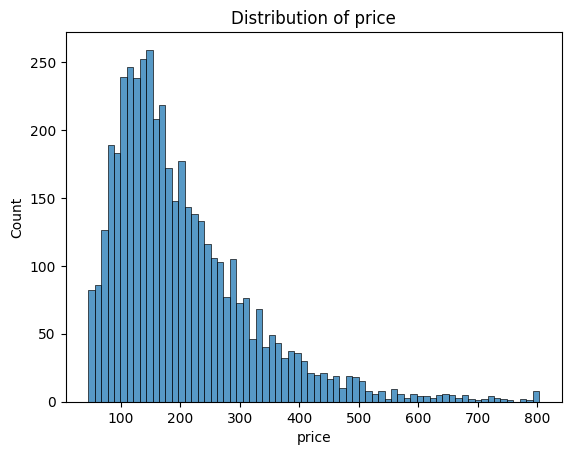

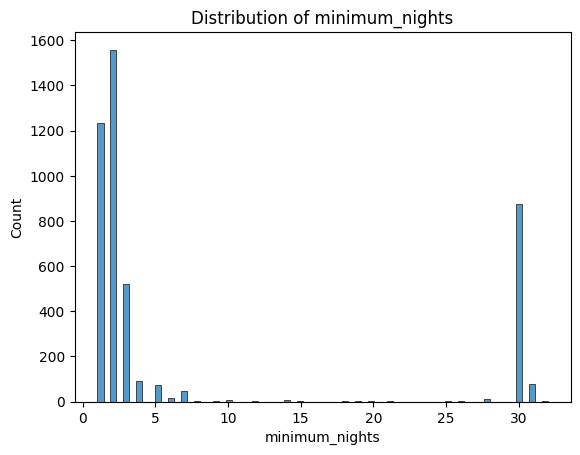

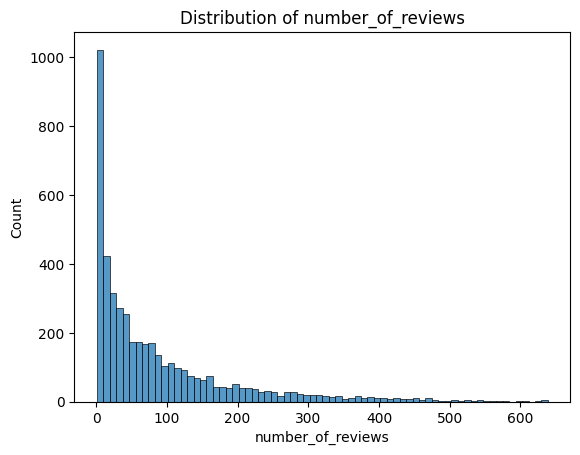

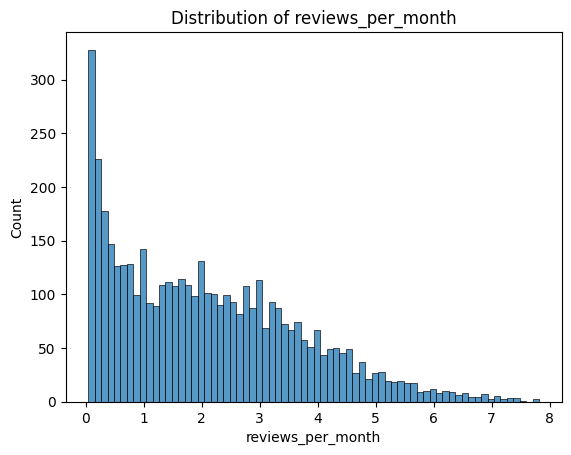

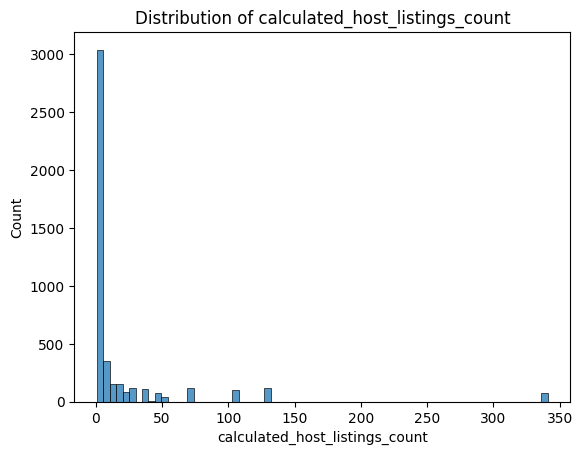

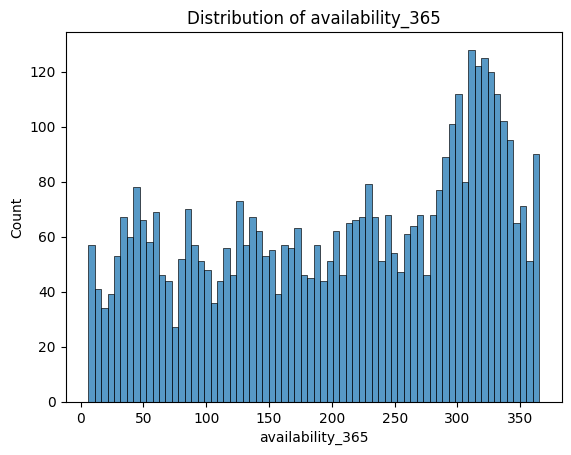

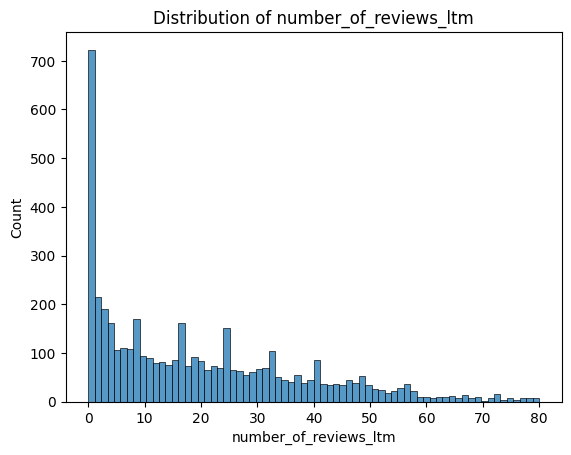

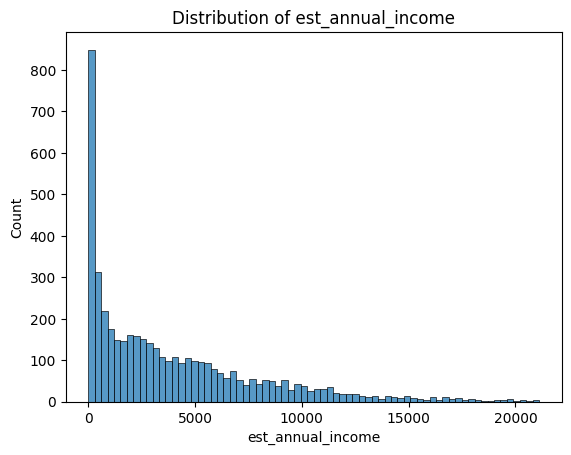

In [43]:
# plots of distribution of data
attributes = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'est_annual_income']
for feature in attributes:
    plot_distribution(top_listings_df_clean, feature, bins = 70)

plt.show()
